In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.colors as mcolors
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

In [2]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] # An array of colors for matplotlib to access

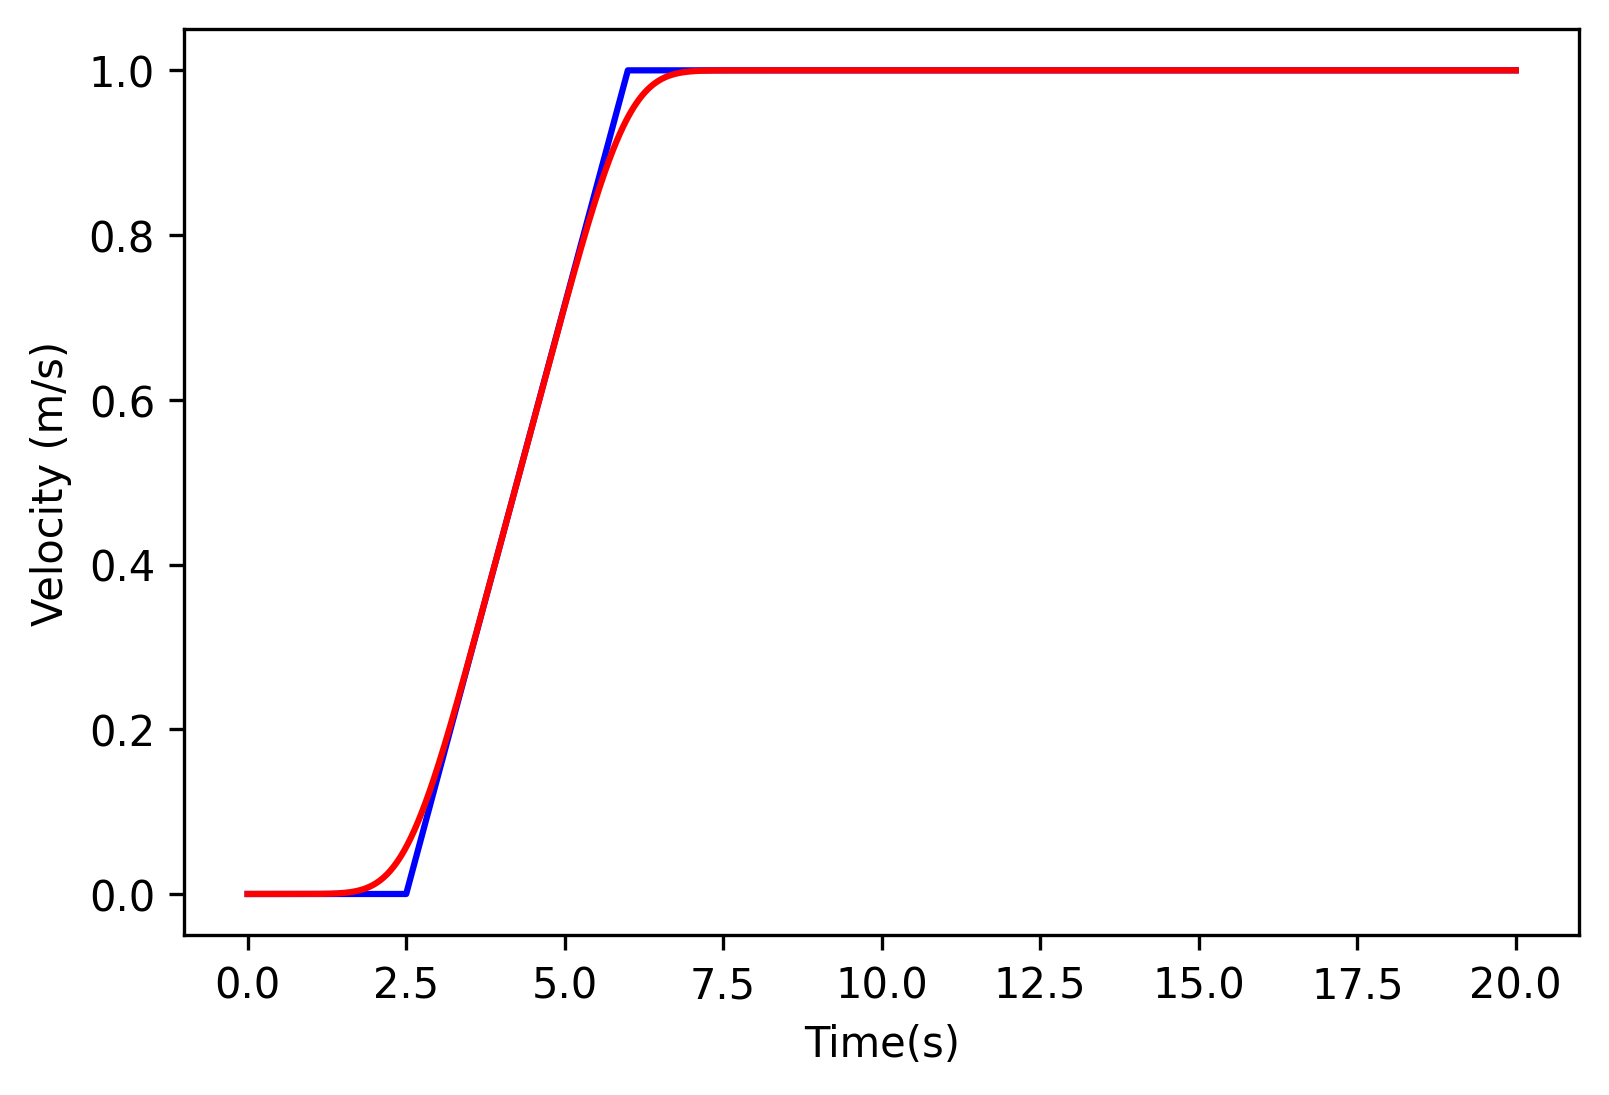

In [3]:
# % VELOCITY PROFILE GENERATION
velocity_final = 1                                                      # Final ball-bot velocity (m/s)
a_start = 2.5                                                          # Start of acceleration (s)

t_final = 20                                                           # Duration of the simulation (s)
t_constant = 6 # Ramp lasts from 2.5 s to t_constant                   # Time to reach constant final velocity (s)
dt = 1/200                                                             # Simulation timestep
t_length = int(t_final/dt)                                             # Length of time vector
t = np.linspace(0, t_final, t_length)                                  # Time vector (s)
        
t_ramp_start = int(a_start / dt)
t_ramp_end = round(t_length*(t_constant/t_final))
# print(t_ramp_start,t_ramp_end)
# print(t_ramp_end-t_ramp_start,(round(t_length*(t_constant/t_final))-500))
linear = np.linspace(0,velocity_final, (t_ramp_end-t_ramp_start) ) 
velocity = np.concatenate((np.zeros(t_ramp_start), linear, velocity_final*np.ones(t_length - t_ramp_end)))                      # Velocity vector (m/s)
smoothed_velocity = gaussian_filter1d(velocity,100)  #Smoothing velocity with a sigma of 100

plt.figure(dpi=300)
plt.plot(t,velocity, colors[0])
plt.xlabel('Time(s)')
plt.ylabel('Velocity (m/s)')
plt.plot(t,smoothed_velocity,colors[2])
plt.show()


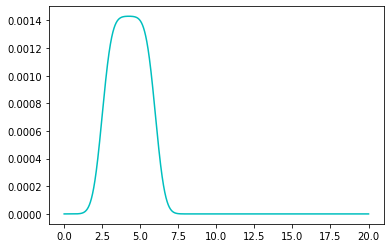

In [4]:
linear_acceleration = np.gradient(smoothed_velocity)
plt.plot(t,linear_acceleration,colors[3])